In [7]:
# Ignore warning
import warnings
warnings.filterwarnings("ignore")

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pandas as pd
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import geopandas
import netCDF4
import h5py
import datetime as dt
import pyproj

import pickle

from scipy.interpolate import griddata

# check pytorch version
import torch    
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler

from datetime import datetime

%load_ext autoreload
%autoreload 2
from functions import *
# from torch_model import *

### Read sea ice drift data

In [76]:
from pyproj import Proj, transform
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3412")

offset = 0.5

lons = np.concatenate((np.arange(168, 181), np.arange(-180, -171)))
lats = np.concatenate((np.ones(len(lons))*(-70+offset), np.ones(len(lons))*(-74+offset), np.array([-70+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([168])))

NW_x, NW_y = transform(inProj,outProj,lons,lats)

lons = (np.arange(-172, -149))
lats = np.concatenate((np.ones(len(lons))*(-70+offset), np.ones(len(lons))*(-74+offset), np.array([-70+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([-172])))

NE_x, NE_y = transform(inProj,outProj,lons,lats)

lons = np.concatenate((np.arange(162, 181), np.arange(-180, -171)))
lats = np.concatenate((np.ones(len(lons))*(-74+offset), np.ones(len(lons))*(-78+offset), np.array([-74+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([162])))

SW_x, SW_y = transform(inProj,outProj,lons,lats)

lons = (np.arange(-172, -149))
lats = np.concatenate((np.ones(len(lons))*(-74+offset), np.ones(len(lons))*(-78+offset), np.array([-74+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([-172])))

SE_x, SE_y = transform(inProj,outProj,lons,lats)

2023-09-03 23:17:39,224 INFO Welcome to the CDS
2023-09-03 23:17:39,226 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-09-03 23:17:39,386 INFO Request is completed
2023-09-03 23:18:28,609 INFO Welcome to the CDS
2023-09-03 23:18:28,611 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-09-03 23:18:28,818 INFO Request is completed
2023-09-03 23:19:14,277 INFO Welcome to the CDS
2023-09-03 23:19:14,277 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-09-03 23:19:14,476 INFO Request is completed
2023-09-03 23:20:02,328 INFO Welcome to the CDS
2023-09-03 23:20:02,328 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-09-03 23:20:02,542 INFO Request is completed


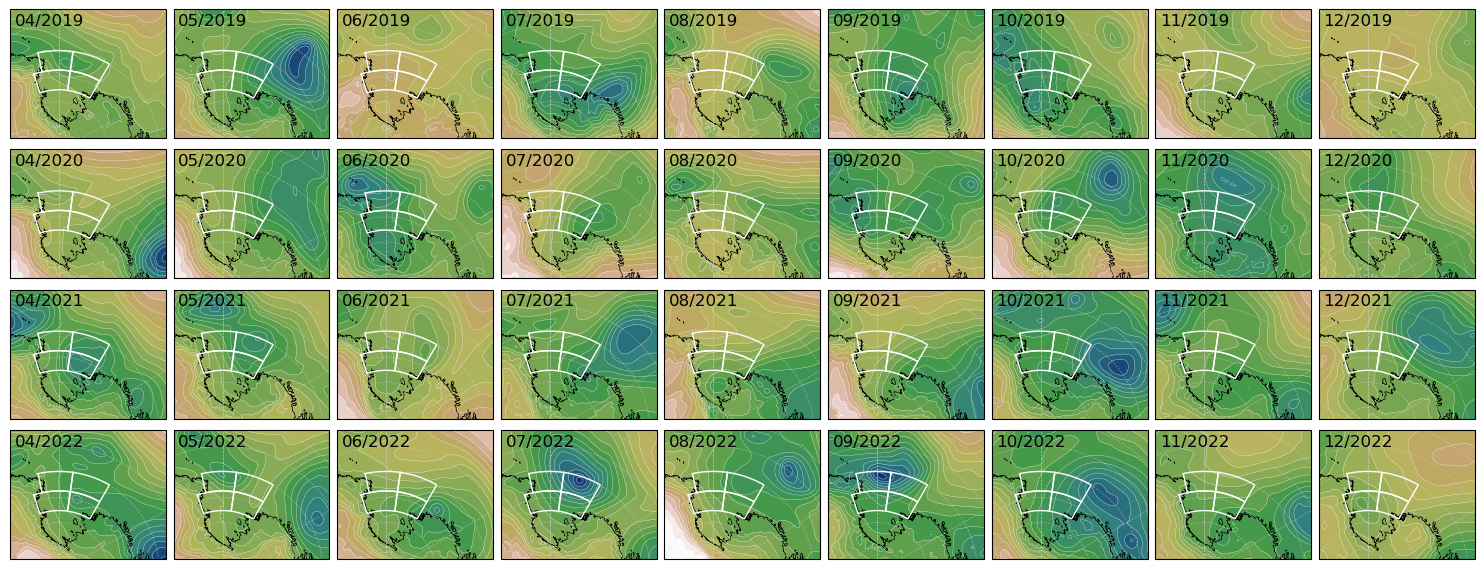

In [253]:
## Visualize sea level pressure
try:
    nc.close()
except:
    pass

ncfile = "D:\\PINN\\data\\SH\\Sea_ice_drift\\icemotion_daily_sh_25km_20190101_20191231_v4.1.nc"
with netCDF4.Dataset(ncfile, 'r') as nc:
    x = np.array(nc.variables['x'])
    y = np.array(nc.variables['y'])
    xx, yy = np.meshgrid(x,y) # "EPSG:3412"

years = [2019, 2020, 2021, 2022]
months = [4,5,6,7,8,9,10,11,12]
fig, ax = plt.subplots(len(years), len(months), figsize=(len(months)*2.1, len(years)*1.8), dpi= 100, subplot_kw={'projection': ccrs.SouthPolarStereo()})
plt.subplots_adjust(hspace=0.05, wspace=0.05)

for i, year in enumerate(years):
    
    ds = retrieve_ERA5_monthly(year, region = "SH")    
    
    for j, m in enumerate(months):
        grid_t2m, grid_u10, grid_v10, grid_sic, grid_sp, grid_sst, grid_msl = get_ERA5(ds, m-1, xx, yy, region = "SH")

        ax[i,j].coastlines('10m', linewidth = 0.5)

        ax[i,j].plot(NW_x, NW_y, lw=1, color = "white")
        ax[i,j].plot(NE_x, NE_y, lw=1, color = "white")
        ax[i,j].plot(SW_x, SW_y, lw=1, color = "white")
        ax[i,j].plot(SE_x, SE_y, lw=1, color = "white")

        gl = ax[i,j].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=0.5, color='lightgrey', alpha=0.5, linestyle='--')

        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
        gl.ylabels_right = False

        xmin, xmax = ax[i,j].set_xlim(1100000, -2400000)
        ymin, ymax = ax[i,j].set_ylim(-300000, -3200000)

        ctf = ax[i,j].contourf(xx, yy, grid_msl, levels=np.arange(920, 1040, 5), lines = "solid", cmap = "gist_earth", extend = "both")
        ct = ax[i,j].contour(xx, yy, grid_msl, levels=np.arange(920, 1040, 5), lines = "solid", colors = "white", linewidths = 0.2)
        # fig.colorbar(ctf, ax = ax[i,j], extend = "both", ticks = np.arange(920, 1020, 20), shrink = 0.5)
        
        ax[i,j].annotate(str(m).zfill(2)+"/"+str(year), xy=(0.03, 0.97), xycoords='axes fraction', fontsize=12, ha='left', va='top')
        # ax[i,j].set_title(str(year)+str(m).zfill(2))

In [237]:
## Visualize sea surface temperature
try:
    nc.close()
except:
    pass

ncfile = "D:\\PINN\\data\\SH\\Sea_ice_drift\\icemotion_daily_sh_25km_20190101_20191231_v4.1.nc"
with netCDF4.Dataset(ncfile, 'r') as nc:
    x = np.array(nc.variables['x'])
    y = np.array(nc.variables['y'])
    xx, yy = np.meshgrid(x,y) # "EPSG:3412"

years = [2018, 2019, 2020, 2021, 2022]
months = [4,5,6,7,8,9,10,11,12]
fig, ax = plt.subplots(len(years), len(months), figsize=(len(months)*2.1, len(years)*1.8), dpi= 100, subplot_kw={'projection': ccrs.SouthPolarStereo()})
plt.subplots_adjust(hspace=0.05, wspace=0.05)

for i, year in enumerate(years):
    
    ds = retrieve_ERA5_monthly(year, region = "SH")    
    
    for j, m in enumerate(months):
        grid_t2m, grid_u10, grid_v10, grid_sic, grid_sp, grid_sst, grid_msl = get_ERA5(ds, m-1, xx, yy, region = "SH")

        ax[i,j].coastlines('10m', linewidth = 0.5)

        ax[i,j].plot(NW_x, NW_y, lw=1, color = "white")
        ax[i,j].plot(NE_x, NE_y, lw=1, color = "white")
        ax[i,j].plot(SW_x, SW_y, lw=1, color = "white")
        ax[i,j].plot(SE_x, SE_y, lw=1, color = "white")

        gl = ax[i,j].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=0.5, color='lightgrey', alpha=0.5, linestyle='--')

        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
        gl.ylabels_right = False

        xmin, xmax = ax[i,j].set_xlim(1100000, -2400000)
        ymin, ymax = ax[i,j].set_ylim(-300000, -3200000)

        ctf = ax[i,j].pcolormesh(xx, yy, grid_sst, vmin = 271, vmax = 274, cmap = "jet")
        # ct = ax[i,j].contour(xx, yy, grid_msl, levels=np.arange(920, 1040, 5), lines = "solid", colors = "white", linewidths = 0.2)
        # fig.colorbar(ctf, ax = ax[i,j], extend = "both", ticks = np.arange(920, 1020, 20), shrink = 0.5)
        
        ax[i,j].annotate(str(year)+str(m).zfill(2), xy=(0.03, 0.97), xycoords='axes fraction', fontsize=12, ha='left', va='top')
        # ax[i,j].set_title(str(year)+str(m).zfill(2))

2023-09-03 22:56:32,444 INFO Welcome to the CDS
2023-09-03 22:56:32,447 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-09-03 22:56:32,637 INFO Request is completed
2023-09-03 22:57:21,438 INFO Welcome to the CDS
2023-09-03 22:57:21,440 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-09-03 22:57:21,628 INFO Request is completed
2023-09-03 22:58:10,011 INFO Welcome to the CDS
2023-09-03 22:58:10,013 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-09-03 22:58:10,217 INFO Request is completed
2023-09-03 22:59:02,082 INFO Welcome to the CDS
2023-09-03 22:59:02,085 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-09-03 22:59:02,257 INFO Request is completed
2023-09-03 22:59:49,240 INFO Welcome

2023-09-03 23:02:24,499 INFO Welcome to the CDS
2023-09-03 23:02:24,507 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-09-03 23:02:24,698 INFO Request is completed
2023-09-03 23:03:09,616 INFO Welcome to the CDS
2023-09-03 23:03:09,616 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-09-03 23:03:09,793 INFO Request is completed
2023-09-03 23:03:55,031 INFO Welcome to the CDS
2023-09-03 23:03:55,031 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-09-03 23:03:55,193 INFO Request is completed
2023-09-03 23:04:40,150 INFO Welcome to the CDS
2023-09-03 23:04:40,150 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-09-03 23:04:40,323 INFO Request is completed
2023-09-03 23:05:25,469 INFO Welcome

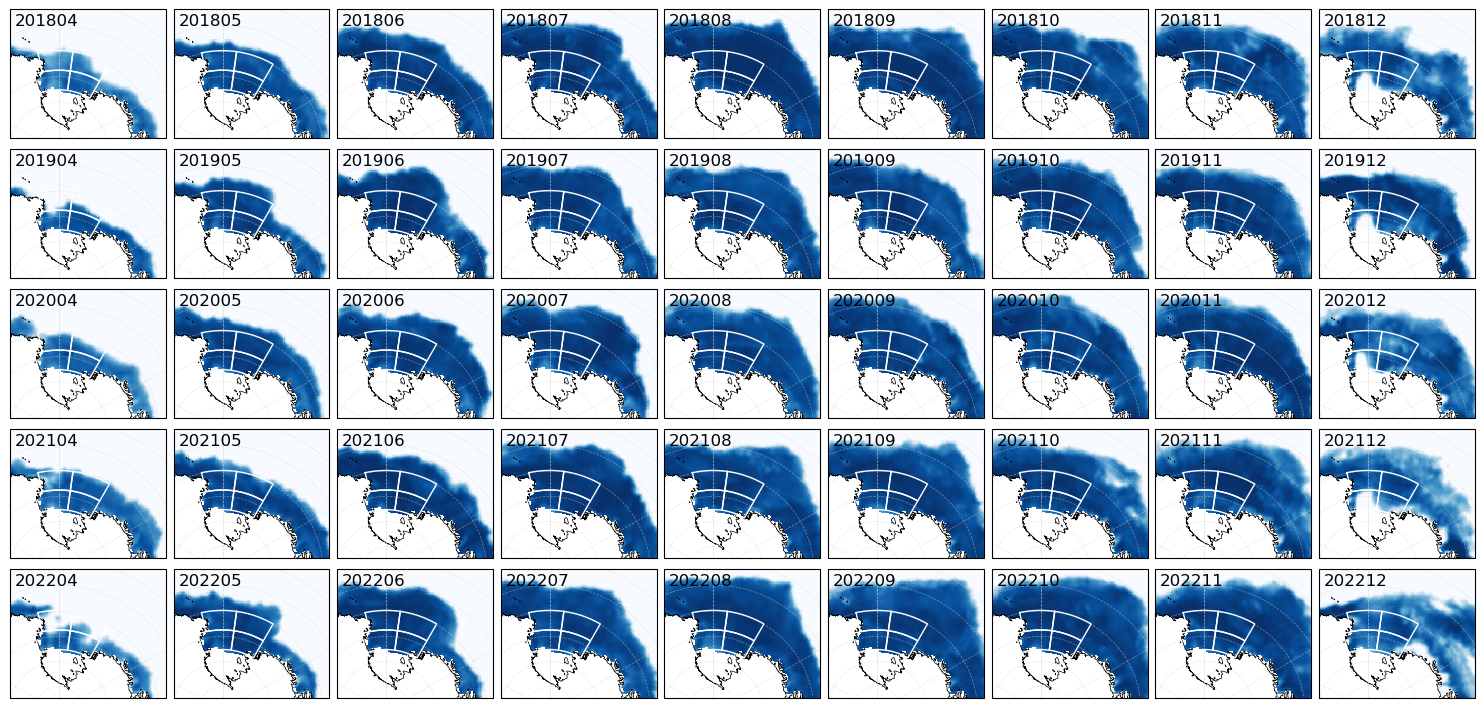

In [241]:
## Visualize SIC
try:
    nc.close()
except:
    pass

ncfile = "D:\\PINN\\data\\SH\\Sea_ice_drift\\icemotion_daily_sh_25km_20190101_20191231_v4.1.nc"
with netCDF4.Dataset(ncfile, 'r') as nc:
    x = np.array(nc.variables['x'])
    y = np.array(nc.variables['y'])
    xx, yy = np.meshgrid(x,y) # "EPSG:3412"

years = [2018, 2019, 2020, 2021, 2022]
months = [4,5,6,7,8,9,10,11,12]
fig, ax = plt.subplots(len(years), len(months), figsize=(len(months)*2.1, len(years)*1.8), dpi= 100, subplot_kw={'projection': ccrs.SouthPolarStereo()})
plt.subplots_adjust(hspace=0.05, wspace=0.05)

for i, year in enumerate(years):
    
    ds = retrieve_ERA5_monthly(year, region = "SH")    
    
    for j, m in enumerate(months):
        grid_t2m, grid_u10, grid_v10, grid_sic, grid_sp, grid_sst, grid_msl = get_ERA5(ds, m-1, xx, yy, region = "SH")

        ax[i,j].coastlines('10m', linewidth = 0.5)

        ax[i,j].plot(NW_x, NW_y, lw=1, color = "white")
        ax[i,j].plot(NE_x, NE_y, lw=1, color = "white")
        ax[i,j].plot(SW_x, SW_y, lw=1, color = "white")
        ax[i,j].plot(SE_x, SE_y, lw=1, color = "white")

        gl = ax[i,j].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=0.5, color='lightgrey', alpha=0.5, linestyle='--')

        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
        gl.ylabels_right = False

        xmin, xmax = ax[i,j].set_xlim(1100000, -2400000)
        ymin, ymax = ax[i,j].set_ylim(-300000, -3200000)

        ctf = ax[i,j].pcolormesh(xx, yy, grid_sic, vmin=0, vmax=1, cmap = "Blues")
        # ct = ax[i,j].contour(xx, yy, grid_msl, levels=np.arange(920, 1040, 5), lines = "solid", colors = "white", linewidths = 0.2)
        # fig.colorbar(ctf, ax = ax[i,j], extend = "both", ticks = np.arange(920, 1020, 20), shrink = 0.5)
        
        ax[i,j].annotate(str(year)+str(m).zfill(2), xy=(0.03, 0.97), xycoords='axes fraction', fontsize=12, ha='left', va='top')
        # ax[i,j].set_title(str(year)+str(m).zfill(2))

2023-09-03 22:47:21,970 INFO Welcome to the CDS
2023-09-03 22:47:21,970 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-09-03 22:47:22,135 INFO Request is completed
2023-09-03 22:48:07,111 INFO Welcome to the CDS
2023-09-03 22:48:07,112 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-09-03 22:48:07,265 INFO Request is completed
2023-09-03 22:48:55,457 INFO Welcome to the CDS
2023-09-03 22:48:55,457 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-09-03 22:48:55,701 INFO Request is completed
2023-09-03 22:49:45,441 INFO Welcome to the CDS
2023-09-03 22:49:45,441 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-09-03 22:49:45,615 INFO Request is completed
2023-09-03 22:50:33,259 INFO Welcome

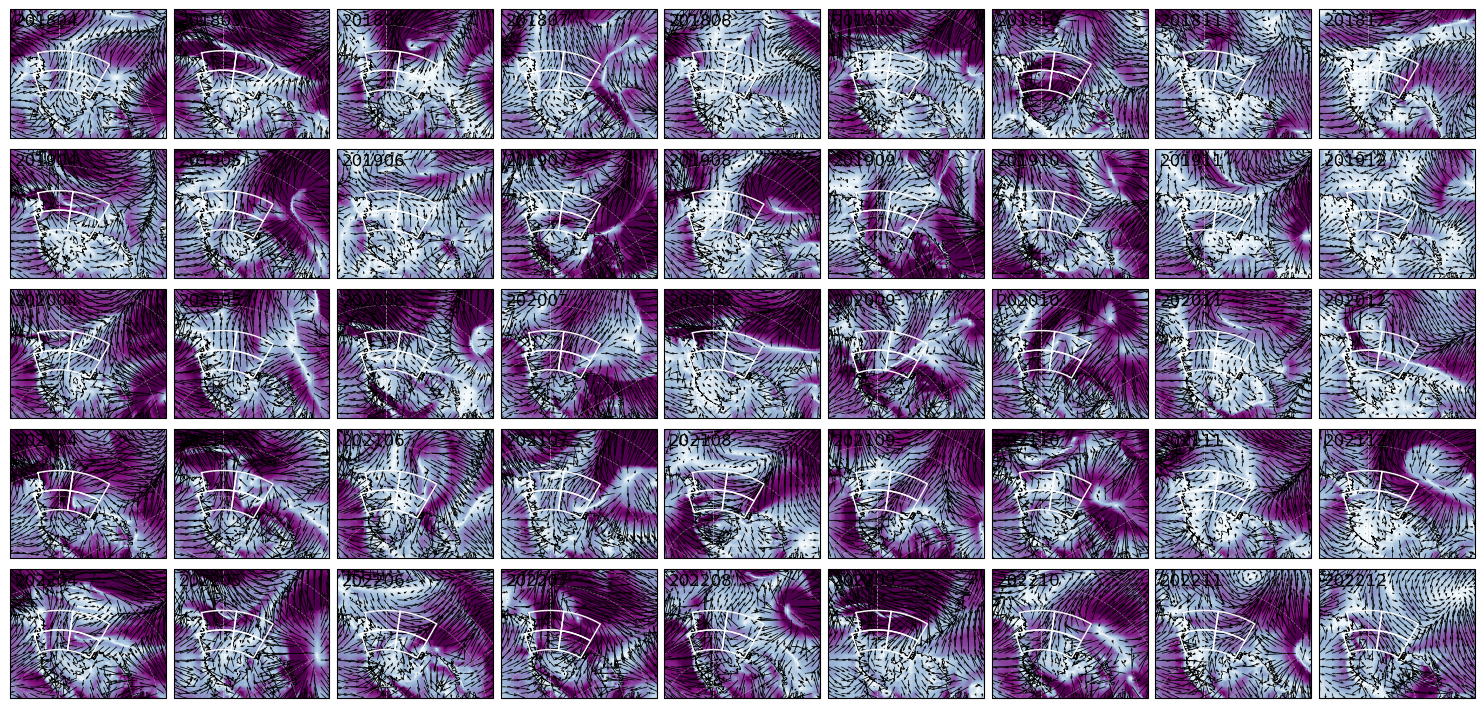

In [216]:
## Visualize wind velocity
try:
    nc.close()
except:
    pass

ncfile = "D:\\PINN\\data\\SH\\Sea_ice_drift\\icemotion_daily_sh_25km_20190101_20191231_v4.1.nc"
with netCDF4.Dataset(ncfile, 'r') as nc:
    x = np.array(nc.variables['x'])
    y = np.array(nc.variables['y'])
    xx, yy = np.meshgrid(x,y) # "EPSG:3412"

years = [2018, 2019, 2020, 2021, 2022]
months = [4,5,6,7,8,9,10,11,12]
fig, ax = plt.subplots(len(years), len(months), figsize=(len(months)*2.1, len(years)*1.8), dpi= 100, subplot_kw={'projection': ccrs.SouthPolarStereo()})
plt.subplots_adjust(hspace=0.05, wspace=0.05)

for i, year in enumerate(years):
    
    ds = retrieve_ERA5_monthly(year, region = "SH")    
    
    for j, m in enumerate(months):
        grid_t2m, grid_u10, grid_v10, grid_sic, grid_sp, grid_sst, grid_msl = get_ERA5(ds, m-1, xx, yy, region = "SH")
        grid_vel = (grid_u10**2 + grid_v10**2)**0.5
        
        ax[i,j].coastlines('10m', linewidth = 0.5)

        ax[i,j].plot(NW_x, NW_y, lw=1, color = "white")
        ax[i,j].plot(NE_x, NE_y, lw=1, color = "white")
        ax[i,j].plot(SW_x, SW_y, lw=1, color = "white")
        ax[i,j].plot(SE_x, SE_y, lw=1, color = "white")

        gl = ax[i,j].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=0.5, color='lightgrey', alpha=0.5, linestyle='--')

        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
        gl.ylabels_right = False

        xmin, xmax = ax[i,j].set_xlim(1100000, -2400000)
        ymin, ymax = ax[i,j].set_ylim(-300000, -3200000)
        
        s = 6
        ax[i,j].pcolormesh(xx, yy, grid_vel, vmin=0, vmax=15, cmap = "BuPu")
        ax[i,j].quiver(xx[::s, ::s], yy[::s, ::s], -grid_u10[::s, ::s], -grid_v10[::s, ::s], scale_units = "inches", scale = 50, width = 0.005)
        
        ax[i,j].annotate(str(year)+str(m).zfill(2), xy=(0.03, 0.97), xycoords='axes fraction', fontsize=12, ha='left', va='top')
        # ax[i,j].set_title(str(year)+str(m).zfill(2))

In [250]:
fig, ax = plt.subplots(2, 2, figsize=(6,6), dpi= 100, subplot_kw={'projection': ccrs.SouthPolarStereo()})
i = 0; j =0
ax[i,j].coastlines('10m', linewidth = 0.5)
grid_vel = (grid_u10**2 + grid_v10**2)**0.5

ax[i,j].plot(NW_x, NW_y, lw=1, color = "white")
ax[i,j].plot(NE_x, NE_y, lw=1, color = "white")
ax[i,j].plot(SW_x, SW_y, lw=1, color = "white")
ax[i,j].plot(SE_x, SE_y, lw=1, color = "white")

gl = ax[i,j].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=0.5, color='lightgrey', alpha=0.5, linestyle='--')

gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_left = False
gl.ylabels_right = False

xmin, xmax = ax[i,j].set_xlim(1000000, -2500000)
ymin, ymax = ax[i,j].set_ylim(-200000, -3200000)
s = 6
ctf = ax[i,j].contourf(xx, yy, grid_msl, levels=np.arange(920, 1040, 5), lines = "solid", cmap = "gist_earth", extend = "both")

# ax[i,j].quiver(xx[::s, ::s], yy[::s, ::s], -grid_u10[::s, ::s], -grid_v10[::s, ::s], scale_units = "inches", scale = 50, width = 0.005)
# ax[i,j].quiver(xx[::s, ::s], yy[::s, ::s], up_mean[::s, ::s], vp_mean[::s, ::s], scale_units = "inches", scale = 1.5, width = 0.005)
# ctf = ax[i,j].contourf(xx, yy, grid_sst, levels=np.arange(260, 290, 1), cmap = "jet")
# ct = ax[i,j].contour(xx, yy, grid_sst, levels=np.arange(920, 1100, 5), lines = "solid", colors = "white", linewidths = 0.2)
fig.colorbar(ctf, ax = ax[i,j], shrink = 1.0, ticks = np.arange(920, 1040, 30), orientation = 'horizontal')

## Snow depth & Snowfall

In [69]:
def retrieve_ERA5_monthly(year):
    c = cdsapi.Client()
    
    # dataset to read
    dataset = 'reanalysis-era5-single-levels-monthly-means'
    # flag to download data
    download_flag = False

    params = {
        'format': 'netcdf',
        'product_type': 'reanalysis',
        'variable': ['large_scale_snowfall', 'snow_density', 'snow_depth', 'snowfall'],
        'year':[str(year)],
        'month': ['01', '02', '03', '04', '05', '06','07', '08', '09','10', '11', '12'],
        'time': '00:00',
        'grid': [1, 0.5],
        'area': [-40, -180, -90, 180]
        }

    # retrieves the path to the file
    fl = c.retrieve(dataset, params)

    # load into memory
    with urlopen(fl.location) as f:
        ds = xr.open_dataset(f.read())

    return ds

def get_ERA5(xx, yy, region = "SH", ref_lon = 0):
    
    ncfile = f"D:\\Ross\\ERA5_snow_2018-2022.nc"
    ds = xr.open_dataset(ncfile)
    
    lsf = np.zeros([ds.time.size, xx.shape[0], xx.shape[1]]) # Large scale snowfall
    rsn = np.zeros([ds.time.size, xx.shape[0], xx.shape[1]]) # snow density
    sd = np.zeros([ds.time.size, xx.shape[0], xx.shape[1]]) # snow depth
    sf = np.zeros([ds.time.size, xx.shape[0], xx.shape[1]]) # snowfall
    
#     with netCDF4.Dataset(ncfile, 'r') as nc:
#     ## Adjust the number of training datasets ===========================
#         print(nc.variables.keys())
#         lsm = np.array(nc.variables['lsm'])    
#         times = np.array(nc.variables['time'])
#         lon = np.array(nc.variables['longitude'])
#         lat = np.array(nc.variables['latitude'])
#         t2m = np.array(nc.variables['t2m'])
#         i10 = np.array(nc.variables['i10fg'])
#         sic = np.array(nc.variables['siconc'])
#         sp = np.array(nc.variables['sp'])
#         wind = ( (np.array(nc.variables['u10']))**2 + (np.array(nc.variables['v10']))**2 ) ** 0.5

#         t2m[(lsm>0) | (t2m <=-30000)] = np.nan
#         i10[(lsm>0) | (i10<=-30000)] = np.nan
#         sic[(lsm>0) | (sic<=-30000)] = np.nan
#         sp[(lsm>0) | (sp<=-30000)] = np.nan
#         wind[(lsm>0)] = np.nan    
    
    lat3, lon3 = np.meshgrid(ds.latitude, ds.longitude)
    inProj = Proj('epsg:4326')
    if ref_lon == 0:
        outProj = Proj('epsg:3412')
    elif ref_lon == -45:
        outProj = Proj('proj4: +proj=stere +lon_0=-45 +lat_0=90 +k=1 +R=6378273 +no_defs')
    
    xx3,yy3 = transform(inProj,outProj,lat3,lon3)
    
    for i in tqdm(range(0, ds.time.size)):
    
        lsf[i] = griddata((xx3.flatten(), yy3.flatten()), np.array(ds.lsf[i]).transpose().flatten(), (xx, yy), method='linear')
        rsn[i] = griddata((xx3.flatten(), yy3.flatten()), np.array(ds.rsn[i]).transpose().flatten(), (xx, yy), method='linear')
        sd[i] = griddata((xx3.flatten(), yy3.flatten()), np.array(ds.sd[i]).transpose().flatten(), (xx, yy), method='linear')
        sf[i] = griddata((xx3.flatten(), yy3.flatten()), np.array(ds.sf[i]).transpose().flatten(), (xx, yy), method='linear')
        
    return ds, lsf, rsn, sd, sf


In [70]:
# ncfile = "D:\\PINN\\data\\SH\\Sea_ice_drift\\icemotion_daily_sh_25km_20190101_20191231_v4.1.nc"
# with netCDF4.Dataset(ncfile, 'r') as nc:
#     x = np.array(nc.variables['x'])
#     y = np.array(nc.variables['y'])
#     lat = np.array(nc.variables['latitude'])
#     lon = np.array(nc.variables['longitude'])
#     xx, yy = np.meshgrid(x,y) # "EPSG:3412"
#     print(nc.variables)
    
xp = np.arange(-2000000, 1500001, 25000)
yp = np.arange(-3200000, -800001, 25000)

xx, yy = np.meshgrid(xp, yp)
lat, lon = transform(Proj("EPSG:3412"), Proj("EPSG:4326"), xx, yy) 

ds, lsf, rsn, sd, sf = get_ERA5(xx, yy, region = "SH")

100%|█████████████████████████████████████████████████████████████████████████████| 60/60 [02:26<00:00,  2.44s/it]


In [72]:
sectors = np.zeros(xx.shape)
sectors.shape

(96, 141)

In [110]:
ds.sf

<xarray.DataArray 'sf' (time: 60, latitude: 101, longitude: 360)>
[2181600 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.0 -178.0 ... 177.0 178.0 179.0
  * latitude   (latitude) float32 -40.0 -40.5 -41.0 -41.5 ... -89.0 -89.5 -90.0
  * time       (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2022-12-01
Attributes:
    units:          m of water equivalent
    long_name:      Snowfall
    standard_name:  lwe_thickness_of_snowfall_amount

In [79]:
sectors = np.zeros(lat.shape)
offset = 0.5

sectors[(lat > -78+offset) & (lat < -74+offset) & ((lon > 162) | (lon < -172))] = 1 # SW
sectors[(lat > -78+offset) & (lat < -74+offset) & ((lon > -172) & (lon < -149))] = 2 # SE
sectors[(lat > -74+offset) & (lat < -70+offset) & ((lon > 168) | (lon < -172))] = 3 # NW
sectors[(lat > -74+offset) & (lat < -70+offset) & ((lon > -172) & (lon < -149))] = 4 # NE

lons = np.concatenate((np.arange(168, 181), np.arange(-180, -171)))
lats = np.concatenate((np.ones(len(lons))*(-70+offset), np.ones(len(lons))*(-74+offset), np.array([-70+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([168])))

NW_x, NW_y = transform(inProj,outProj,lons,lats)

lons = (np.arange(-172, -149))
lats = np.concatenate((np.ones(len(lons))*(-70+offset), np.ones(len(lons))*(-74+offset), np.array([-70+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([-172])))

NE_x, NE_y = transform(inProj,outProj,lons,lats)

lons = np.concatenate((np.arange(162, 181), np.arange(-180, -171)))
lats = np.concatenate((np.ones(len(lons))*(-74+offset), np.ones(len(lons))*(-78+offset), np.array([-74+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([162])))

SW_x, SW_y = transform(inProj,outProj,lons,lats)

lons = (np.arange(-172, -149))
lats = np.concatenate((np.ones(len(lons))*(-74+offset), np.ones(len(lons))*(-78+offset), np.array([-74+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([-172])))

SE_x, SE_y = transform(inProj,outProj,lons,lats)

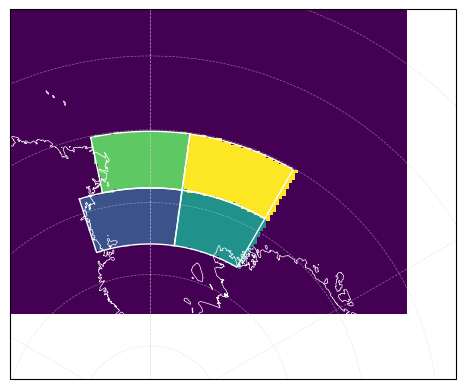

In [80]:
fig, ax = plt.subplots(1,1, subplot_kw={'projection': ccrs.SouthPolarStereo(true_scale_latitude = -90)})
plt.pcolormesh(xx, yy, sectors)
ax.plot(NW_x, NW_y, lw=1, color = "white")
ax.plot(NE_x, NE_y, lw=1, color = "white")
ax.plot(SW_x, SW_y, lw=1, color = "white")
ax.plot(SE_x, SE_y, lw=1, color = "white")
xmin, xmax = ax.set_xlim(1100000, -2400000)
ymin, ymax = ax.set_ylim(-300000, -3200000)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=0.5, color='lightgrey', alpha=0.5, linestyle='--')
ax.coastlines('10m', linewidth = 0.5, color = "white")

In [116]:
idx

35

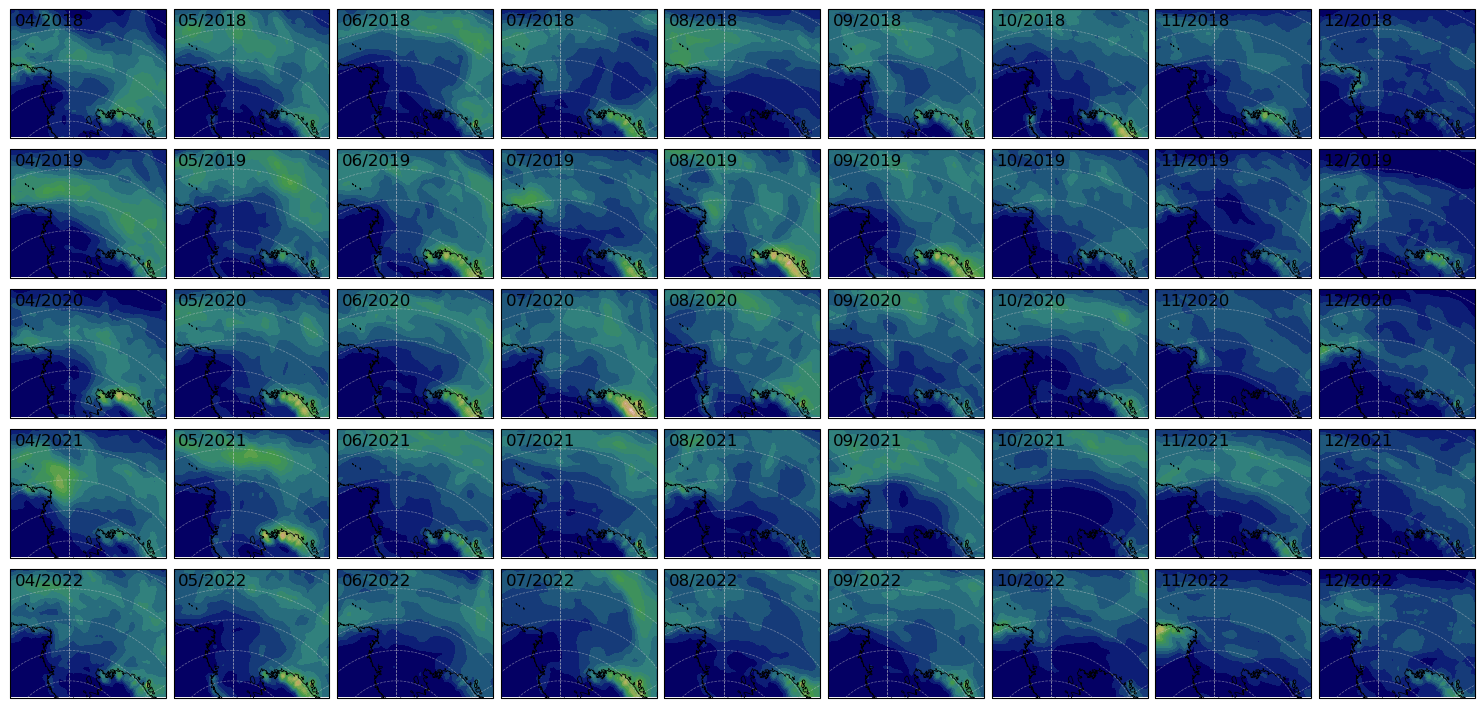

In [117]:
# ## Visualize sea level pressure
# try:
#     nc.close()
# except:
#     pass

# ncfile = "D:\\PINN\\data\\SH\\Sea_ice_drift\\icemotion_daily_sh_25km_20190101_20191231_v4.1.nc"
# with netCDF4.Dataset(ncfile, 'r') as nc:
#     x = np.array(nc.variables['x'])
#     y = np.array(nc.variables['y'])
#     lat = np.array(nc.variables['latitude'])
#     lon = np.array(nc.variables['longitude'])
#     xx, yy = np.meshgrid(x,y) # "EPSG:3412"

# ds, lsf, rsn, sd, sf = get_ERA5(xx, yy, region = "SH")

years = [2018, 2019, 2020, 2021, 2022]
months = [4,5,6,7,8,9,10,11,12]
fig, ax = plt.subplots(len(years), len(months), figsize=(len(months)*2.1, len(years)*1.8), dpi= 100, subplot_kw={'projection': ccrs.SouthPolarStereo()})
plt.subplots_adjust(hspace=0.05, wspace=0.05)

for i, year in enumerate(years):    
    
    for j, m in enumerate(months):        
        
        idx = np.where((ds.time.dt.year == year) & (ds.time.dt.month == m))[0][0]

        ax[i,j].coastlines('10m', linewidth = 0.5)

        ax[i,j].plot(NW_x, NW_y, lw=1, color = "white")
        ax[i,j].plot(NE_x, NE_y, lw=1, color = "white")
        ax[i,j].plot(SW_x, SW_y, lw=1, color = "white")
        ax[i,j].plot(SE_x, SE_y, lw=1, color = "white")

        gl = ax[i,j].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=0.5, color='lightgrey', alpha=0.5, linestyle='--')

        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
        gl.ylabels_right = False

        # xmin, xmax = ax[i,j].set_xlim(1100000, -2400000)
        # ymin, ymax = ax[i,j].set_ylim(-300000, -3200000)
        
        xmin, xmax = ax[i,j].set_xlim(1100000, -1800000)
        ymin, ymax = ax[i,j].set_ylim(-800000, -3200000)
        
        ctf = ax[i,j].contourf(xx, yy, sf[idx]*100, levels=np.arange(0, 1, 0.05), lines = "solid", cmap = "gist_earth", extend = "both")
        # ctf = ax[i,j].contourf(xx, yy, grid_msl, levels=np.arange(920, 1040, 5), lines = "solid", cmap = "gist_earth", extend = "both")
        # ct = ax[i,j].contour(xx, yy, grid_msl, levels=np.arange(920, 1040, 5), lines = "solid", colors = "white", linewidths = 0.2)
        # fig.colorbar(ctf, ax = ax[i,j], extend = "both", ticks = np.arange(920, 1020, 20), shrink = 0.5)
        
        ax[i,j].annotate(str(m).zfill(2)+"/"+str(year), xy=(0.03, 0.97), xycoords='axes fraction', fontsize=12, ha='left', va='top')
        # ax[i,j].set_title(str(year)+str(m).zfill(2))

In [87]:
idx = np.where((ds.time.dt.year == 2020) & (ds.time.dt.month == 12))[0][0]

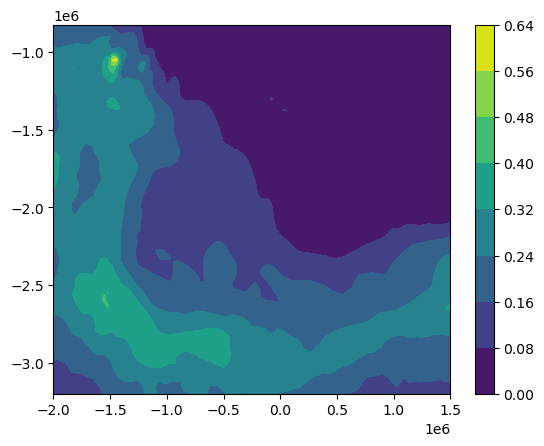

In [112]:
plt.contourf(xx, yy, sf[5]*100)
plt.colorbar()

In [82]:
sd.shape

(60, 96, 141)

In [ ]:
from pyproj import Proj, transform
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3409")

offset = 0.5

lons = np.concatenate((np.arange(168, 181), np.arange(-180, -171)))
lats = np.concatenate((np.ones(len(lons))*(-70+offset), np.ones(len(lons))*(-74+offset), np.array([-70+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([168])))

NW_x, NW_y = transform(inProj,outProj,lons,lats)

lons = (np.arange(-172, -149))
lats = np.concatenate((np.ones(len(lons))*(-70+offset), np.ones(len(lons))*(-74+offset), np.array([-70+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([-172])))

NE_x, NE_y = transform(inProj,outProj,lons,lats)

lons = np.concatenate((np.arange(162, 181), np.arange(-180, -171)))
lats = np.concatenate((np.ones(len(lons))*(-74+offset), np.ones(len(lons))*(-78+offset), np.array([-74+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([162])))

SW_x, SW_y = transform(inProj,outProj,lons,lats)

lons = (np.arange(-172, -149))
lats = np.concatenate((np.ones(len(lons))*(-74+offset), np.ones(len(lons))*(-78+offset), np.array([-74+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([-172])))

SE_x, SE_y = transform(inProj,outProj,lons,lats)

In [192]:
fig, ax = plt.subplots(2, 2, figsize=(6,6), dpi= 100, subplot_kw={'projection': ccrs.SouthPolarStereo()})
i = 0; j =0
ax[i,j].coastlines('10m', linewidth = 0.5)
grid_vel = (grid_u10**2 + grid_v10**2)**0.5

# ax[i,j].plot(NW_x, NW_y, lw=1, color = "white")
# ax[i,j].plot(NE_x, NE_y, lw=1, color = "white")
# ax[i,j].plot(SW_x, SW_y, lw=1, color = "white")
# ax[i,j].plot(SE_x, SE_y, lw=1, color = "white")

gl = ax[i,j].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=0.5, color='lightgrey', alpha=0.5, linestyle='--')

gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_left = False
gl.ylabels_right = False

xmin, xmax = ax[i,j].set_xlim(-4000000, 4000000)
ymin, ymax = ax[i,j].set_ylim(-4000000, 4000000)

In [49]:
grid_t2m, grid_u10, grid_v10, grid_sic, grid_sp, grid_sst, grid_msl = get_ERA5(ds, 0, xx, yy, region = "SH")

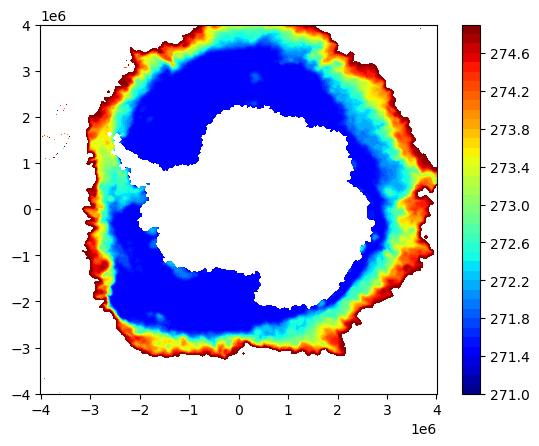

In [161]:
cp = plt.contourf(xx, yy, grid_sst, levels=np.arange(271, 275, 0.1), cmap = "jet")
# cp = plt.pcolormesh(xx, yy, grid_sst, vmax = 280, vmin = 260, cmap = "jet")
fig.colorbar(cp)

In [23]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 360, latitude: 101, time: 365)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.0 -178.0 ... 177.0 178.0 179.0
  * latitude   (latitude) float32 -40.0 -40.5 -41.0 -41.5 ... -89.0 -89.5 -90.0
  * time       (time) datetime64[ns] 2018-01-01T12:00:00 ... 2018-12-31T12:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    siconc     (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-04 00:37:31 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [ ]:
def make_dataset(year, n_samples, ds, w = 1, datatype = "entire", region = "NH"):
    # ncfile = glob.glob("F:\\2022_Ross\\ERA5\\icemotion_daily_sh_25km_{0}*.nc".format(year))[0]
    ncfile = data_path + f"/{region}/Sea_ice_drift/icemotion_daily_nh_25km_{year}0101_{year}1231_v4.1.nc"
    with netCDF4.Dataset(ncfile, 'r') as nc:
    ## Adjust the number of training datasets ===========================
        days = np.array(nc.variables['time']).astype(float)[:]
        row, col = np.shape(np.array(nc.variables['latitude']))
        
    # Initialize grid input ==========================================
    grid_input = np.zeros([len(n_samples), row, col, 7])
    grid_output = np.zeros([len(n_samples), row, col, 4])
    
    valid = []
    first = True
    
    for i, idx in tqdm(enumerate(n_samples)):
        t1 = dt.datetime(1970, 1, 1) + dt.timedelta(days = days[idx])
        t2 = dt.datetime(1970, 1, 1) + dt.timedelta(days = days[idx]+1)  
        
        valid.append(i)

        ## Read ice motion data ===========================================
        sampling_size = 1
        xx, yy, lat, lon, u, v = get_ice_motion(ncfile, idx, sampling_size)
        grid_u = np.mean(u, axis = 0)
        grid_v = np.mean(v, axis = 0)

        ## Read SIC data ==================================================
        grid_sic = get_SIC(t1, xx, yy, region = region)

        ## Read ERA5 data =================================================
        grid_t2m, grid_u10, grid_v10, _ = get_ERA5(ds, idx, xx, yy, region = region)

        grid_input[i, :, :, 0] = grid_u / 50
        grid_input[i, :, :, 1] = grid_v / 50
        grid_input[i, :, :, 2] = grid_sic
        grid_input[i, :, :, 3] = (grid_t2m - 210)/(310 - 210) #Max temp = 320 K, Min temp = 240 K)
        grid_input[i, :, :, 4] = grid_u10 / 50
        grid_input[i, :, :, 5] = grid_v10 / 50

        _, _, _, _, u2, v2 = get_ice_motion(ncfile, idx+1, sampling_size)
        grid_u2 = np.mean(u2, axis = 0)
        grid_v2 = np.mean(v2, axis = 0) 
        grid_output[i, :, :, 0] = grid_u2 / 50
        grid_output[i, :, :, 1] = grid_v2 / 50
        grid_sic2 = get_SIC(t2, xx, yy, region = region)
        # _, _, _, grid_sic2 = get_ERA5(ds, idx+1, xx, yy, region = region)
        grid_output[i, :, :, 2] = grid_sic2

        # Masking ======================================
        mask1 = (grid_sic == 0) #(np.isnan(grid_u))
        mask2 = (grid_sic2 == 0) #(np.isnan(grid_u2))

        if datatype == "cell":
            xx1, yy1 = [], []
            for m in range(w, row-w):
                for n in range(w, col-w):
                    ip = np.array([grid_input[i, m-w:m+w+1, n-w:n+w+1, :]])
                    if mask1[m,n] == False: #np.prod(ip[0, :, :, 2]) > 0:
                        op = np.array([grid_output[i, m-w:m+w+1, n-w:n+w+1, :]])
                        xx1.append(xx[m, n])
                        yy1.append(yy[m, n])
                        if first:
                            conv_input = ip
                            conv_output = op
                            first = False
                        else:
                            conv_input = np.concatenate((conv_input, ip), axis = 0)
                            conv_output = np.concatenate((conv_output, op), axis = 0)            

        elif datatype == "entire":
            var_ip = np.shape(grid_input)[3]
            var_op = np.shape(grid_output)[3]

            conv_input = np.copy(grid_input)
            conv_output = np.copy(grid_output)

            for m in range(0, var_ip):
                subset = grid_input[i, :, :, m]
                subset[mask1] = 0
                conv_input[i, :, :, m] = subset

            for n in range(0, var_op):
                subset = grid_output[i, :, :, n]
                subset[mask2] = 0
                conv_output[i, :, :, n] = subset

            xx1, yy1 = xx, yy

        elif datatype == "table":

            xx1, yy1 = [], []
            for m in range(w, row-w):
                for n in range(w, col-w):
                    ip = np.array([grid_input[i, m-w:m+w+1, n-w:n+w+1, :].flatten()])
                    if np.prod(grid_sic[m-w:m+w+1, n-w:n+w+1]) > 0:
                        op = np.array([grid_output[i, m-w:m+w+1, n-w:n+w+1, :].flatten()])
                        xx1.append(xx[m, n])
                        yy1.append(yy[m, n])

                        if first:
                            conv_input = ip
                            conv_output = op
                            first = False
                        else:
                            conv_input = np.concatenate((conv_input, ip), axis = 0)
                            conv_output = np.concatenate((conv_output, op), axis = 0)  
    
    if datatype == "entire":
        conv_input = conv_input[np.array(valid), :, :, :]
        conv_output = conv_output[np.array(valid), :, :, :]
    
    return xx1, yy1, conv_input, conv_output, valid

## Unet results check (new version)

In [227]:
first = True
data_path = "../data/"
year = 2022

with open(data_path + '/train_cnn_2013_2022_v4.pkl', 'rb') as file:
    xx, yy, days, months, years, _, _ = pickle.load(file)

mask = (years == year)
days = days[mask]
months = months[mask]
years = years[mask]

pred_cnn = np.zeros([len(days), 5, xx.shape[0], xx.shape[1]])
pred_unet = np.zeros([len(days), 5, xx.shape[0], xx.shape[1]])
target_all = np.zeros([len(days), 5, xx.shape[0], xx.shape[1]])

model_name = f"../results/test_torch_unet_sit_lr0.001_wo{year}_nophy_*.pkl"

# Unet
results = sorted(glob.glob(data_path + model_name))
id_start = 0

mean_values = []

for res in results:
    with open(res, 'rb') as file:
        [data, target, pred] = pickle.load(file)

    prd_vel = np.sqrt(pred[:, 0, :, :]**2 + pred[:, 1, :, :]**2)
    obs_vel = np.sqrt(target[:, 0, :, :]**2 + target[:, 1, :, :]**2)

    pred = np.append(pred, np.expand_dims(prd_vel, axis = 1), axis = 1)
    target = np.concatenate((target, np.expand_dims(obs_vel, axis = 1)), axis = 1)
    
    pred_unet[id_start:id_start+pred.shape[0], :, :, :] = pred
    target_all[id_start:id_start+pred.shape[0], :, :, :] = target

    id_start += pred.shape[0]

print("Unet result DONE!")

# CNN
model_name = f"../results/test_torch_cnn_sit_lr0.001_wo{year}_nophy_*.pkl"

results = sorted(glob.glob(data_path + model_name))
id_start = 0

for res in results:
    with open(res, 'rb') as file:
        [data, target, pred] = pickle.load(file)

    prd_vel = np.sqrt(pred[:, 0, :, :]**2 + pred[:, 1, :, :]**2)
    obs_vel = np.sqrt(target[:, 0, :, :]**2 + target[:, 1, :, :]**2)

    pred = np.append(pred, np.expand_dims(prd_vel, axis = 1), axis = 1)
    target = np.concatenate((target, np.expand_dims(obs_vel, axis = 1)), axis = 1)
    
    pred_cnn[id_start:id_start+pred.shape[0], :, :, :] = pred
    target_all[id_start:id_start+pred.shape[0], :, :, :] = target

    id_start += pred.shape[0]

print("CNN result DONE!")

    

Unet result DONE!
CNN result DONE!


In [107]:
# Model results - HYCOM
data_path = "D:\\PINN\\data\\NH\\Model_forcast\\"
files = glob.glob(data_path + f"{year}*.nc")

pred_hycom = np.zeros([len(files), 5, xx.shape[0], xx.shape[1]])

dates = []
# dates = [datetime.strptime(str(year)+str(d).zfill(3), "%Y%j") for d in days]
# data_path = "D:\\PINN\\data\\NH\\Model_forcast\\"

for i, file in tqdm(enumerate(files)):
    dates.append(datetime.strptime(os.path.basename(file)[:8], "%Y%m%d"))
    # datestr = datetime.strftime(d, "%Y%m%d")
    # file = glob.glob(data_path + f"{datestr}*.nc")[0]
    
    with netCDF4.Dataset(file, 'r') as nc:
        lat = np.array(nc.variables['latitude'])
        lon = np.array(nc.variables['longitude'])
        ui = np.array(nc.variables['uice'])[0] 
        vi = np.array(nc.variables['vice'])[0]
        ai = np.array(nc.variables['fice'])[0]
        hi = np.array(nc.variables['hice'])[0]
        
        ui[ui < -32000] = 0; ui = ui *3600*24/1000
        vi[vi < -32000] = 0; vi = vi *3600*24/1000
        ai[ai < -32000] = 0
        hi[hi < -32000] = 0     
        
    # ESPG:3411 (NSIDC Sea Ice Polar Stereographic North - SIC data)
    inProj = Proj('epsg:4326')
    outProj = Proj('epsg:3408')

    xx2,yy2 = transform(inProj,outProj,lat,lon)
    u10, v10 = rotate_vector(u10, v10, lon3)
    grid_ui = griddata((xx2.flatten(), yy2.flatten()), ui.flatten(), (xx, yy), method='linear')
    grid_vi = griddata((xx2.flatten(), yy2.flatten()), vi.flatten(), (xx, yy), method='linear')
    grid_ai = griddata((xx2.flatten(), yy2.flatten()), ai.flatten(), (xx, yy), method='linear')
    grid_hi = griddata((xx2.flatten(), yy2.flatten()), hi.flatten(), (xx, yy), method='linear')
    grid_vel = (grid_ui**2 + grid_vi**2)**0.5
        
    pred_hycom[i, 0, :, :] = grid_ui
    pred_hycom[i, 1, :, :] = grid_vi
    pred_hycom[i, 2, :, :] = grid_ai
    pred_hycom[i, 3, :, :] = grid_hi
    pred_hycom[i, 4, :, :] = grid_vel
    
with open(f'../data/pred_hycom_{year}.pkl', 'wb') as file:
    pickle.dump([pred_hycom, dates], file)

365it [2:38:59, 26.13s/it]


In [75]:
# Model results - HYCOM CICE
data_path = "D:\\PINN\\data\\NH\\CICE\\"
files = glob.glob(data_path + f"CICE_{year}*.nc")

pred_cice = np.zeros([len(files), 5, xx.shape[0], xx.shape[1]])

dates = []
# dates = [datetime.strptime(str(year)+str(d).zfill(3), "%Y%j") for d in days]
# data_path = "D:\\PINN\\data\\NH\\Model_forcast\\"

for i, file in tqdm(enumerate(files[:])):
    dates.append(datetime.strptime(os.path.basename(file)[-13:-3], "%Y-%m-%d"))
    # datestr = datetime.strftime(d, "%Y%m%d")
    # file = glob.glob(data_path + f"{datestr}*.nc")[0]
    
    with netCDF4.Dataset(file, 'r') as nc:
        lat = np.array(nc.variables['lat'])
        lon = np.array(nc.variables['lon'])
        ui = np.array(nc.variables['siu'])[0] 
        vi = np.array(nc.variables['siv'])[0]
        ai = np.array(nc.variables['sic'])[0]
        hi = np.array(nc.variables['sih'])[0]
        
        ui[ui < -10000] = 0; ui = ui *3600*24/1000 # convert to km/h
        vi[vi < -10000] = 0; vi = vi *3600*24/1000 # convert to km/h
        ai[ai < -10000] = 0
        hi[hi < -10000] = 0     
        
    # ESPG:3411 (NSIDC Sea Ice Polar Stereographic North - SIC data)
    inProj = Proj('epsg:4326')
    outProj = Proj('epsg:3408')

    lons, lats = np.meshgrid(lon, lat)
    ui, vi = rotate_vector(ui, vi, lons)
    xx2,yy2 = transform(inProj,outProj,lats,lons)
    grid_ui = griddata((xx2.flatten(), yy2.flatten()), ui.flatten(), (xx, yy), method='linear')
    grid_vi = griddata((xx2.flatten(), yy2.flatten()), vi.flatten(), (xx, yy), method='linear')
    grid_ai = griddata((xx2.flatten(), yy2.flatten()), ai.flatten(), (xx, yy), method='linear')
    grid_hi = griddata((xx2.flatten(), yy2.flatten()), hi.flatten(), (xx, yy), method='linear')
    grid_vel = (grid_ui**2 + grid_vi**2)**0.5
        
    pred_cice[i, 0, :, :] = grid_ui
    pred_cice[i, 1, :, :] = grid_vi
    pred_cice[i, 2, :, :] = grid_ai
    pred_cice[i, 3, :, :] = grid_hi
    pred_cice[i, 4, :, :] = grid_vel
    
with open(f'../data/pred_cice_{year}.pkl', 'wb') as file:
    pickle.dump([pred_cice, dates], file)

365it [12:01,  1.98s/it]


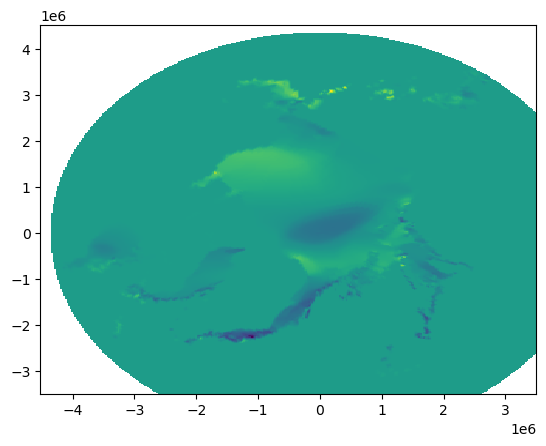

In [79]:
plt.pcolormesh(xx, yy, grid_ui)

In [61]:
lats.shape

(375, 84)

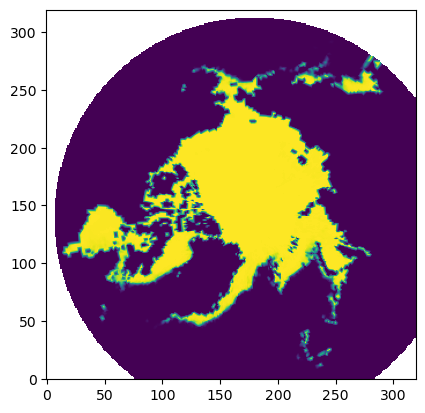

In [68]:
plt.imshow(grid_ai, origin = "lower")

In [72]:
from urllib.request import urlretrieve
date = "2022-02-01"
url = f"https://ncss.hycom.org/thredds/ncss/GLBy0.08/expt_93.0/ice?var=sic&var=sih&var=siu&var=siv&maxy=90&minx=0&maxx=360&miny=50&horizStride=6&time={date}&addLatLon=true&accept=netcdf4"
# data_path = "D:\\PINN\\data\\NH\\CICE\\"
filename = f"CICE_{date}.nc"
urlretrieve(url, filename);

In [77]:
with netCDF4.Dataset(filename, 'r') as nc:
    lat2 = np.array(nc.variables['lat'])
    lon2 = np.array(nc.variables['lon'])
    print(lat2[1] - lat2[0], lon2[1] - lon2[0])
    
    lats, lons = np.meshgrid(lat2, lon2)
    xx2,yy2 = transform(inProj,outProj,lats,lons)

0.24000167846679688 0.47998046875


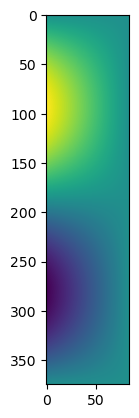

In [69]:
plt.imshow(xx2)